In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

pm   = pd.read_csv('/content/drive/MyDrive/시계열데이터분석/전처리/서울_자치구_PM25_2020_2021_24개월_변경.csv')
er   = pd.read_csv('/content/drive/MyDrive/시계열데이터분석/전처리/er_filtered_2020_2021.csv')
temp = pd.read_csv('/content/drive/MyDrive/시계열데이터분석/전처리/temp_processed_2020_2021.csv')

# 2. 날짜 컬럼을 연-월 시계열로 통일 (Period → Timestamp)
# Assuming the 'Year_Month' column in pm is in 'YYYY-MM-DD' format
pm['year_month']   = pd.to_datetime(pm['Year_Month']).dt.to_period('M').dt.to_timestamp()

# Examining the 'er' dataframe, the format seems to be 'YYYY-MM-DD'
er['year_month']   = pd.to_datetime(er['year_month'], format='%Y-%m-%d').dt.to_period('M').dt.to_timestamp()

# Examining the 'temp' dataframe, the format seems to be 'YYYY-MM-DD'
temp['year_month'] = pd.to_datetime(temp['year_month'], format='%Y-%m-%d').dt.to_period('M').dt.to_timestamp()

# 3. 월별 PM2.5 평균 계산
agg_pm = (
    pm
    .groupby('year_month')['PM2.5']
    .mean()
    .reset_index()
    .rename(columns={'PM2.5':'pm25_mean'})
)

# 4. 월별 ER 방문 수 합계 계산
agg_er = (
    er
    .groupby('year_month')['visit_count']
    .sum()
    .reset_index()
    .rename(columns={'visit_count':'visit_count'})
)

# 5. 월별 기온 이동평균(Temp) 준비
temp_monthly = temp.rename(columns={'TA_MAVG':'TA_MAVG'})[['year_month','TA_MAVG']]

# 6. 2020-01 ~ 2021-12 전체 월 인덱스 생성 후, advisory/alert 더미 추가
all_months = pd.DataFrame({
    'year_month': pd.date_range('2020-01-01','2021-12-01', freq='MS')
})
all_months['advisory'] = 0
all_months['alert']    = 0

# 7. 위에서 계산한 데이터프레임들을 병합(Left Join)
merged = (
    all_months
    .merge(agg_pm,         on='year_month', how='left')
    .merge(agg_er,         on='year_month', how='left')
    .merge(temp_monthly,   on='year_month', how='left')
)

# 8. 결측값(NA)이 있는 경우 전방 채우기
merged['pm25_mean'].fillna(method='ffill', inplace=True)
merged['visit_count'].fillna(method='ffill', inplace=True)
merged['TA_MAVG'].fillna(method='ffill', inplace=True)

# 9. 인덱스를 연-월 시계열로 설정
merged.set_index('year_month', inplace=True)

# 10. **2020-01 ~ 2021-12 전체 데이터를 학습용(train)으로 사용**하여 SARIMAX 모델 학습
train = merged.copy()

model = SARIMAX(
    train['visit_count'],                      # 종속변수: ER 방문 수 (레벨)
    exog=train[['pm25_mean','TA_MAVG']],       # 외생변수: 월별 PM2.5 평균, 기온 이동평균
    order=(1,1,1),                             # ARIMA(p=1,d=1,q=1)
    seasonal_order=(1,1,1,12),                 # SARIMA(P=1,D=1,Q=1,S=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)  # 학습

# 11. **2026년(1월~12월) 예측**을 위한 날짜 인덱스 생성
future_index = pd.date_range(start="2026-01-01", end="2026-12-01", freq='MS')

# 12. 마지막 관측(2021-12)의 외생변수를 베이스로 동일하게 “연속 반복”하여 예측 시나리오용 exog 생성
last_exog = train[['pm25_mean','TA_MAVG']].iloc[-1]
future_exog_base = pd.DataFrame({
    'pm25_mean': np.repeat(float(last_exog['pm25_mean']), len(future_index)),
    'TA_MAVG':   np.repeat(float(last_exog['TA_MAVG']),   len(future_index))
}, index=future_index)

# 13. **시나리오별 외생변수 생성**
#   1) Base Scenario: 그대로
#   2) PM+30 Scenario: pm25_mean + 30
#   3) PM-20 Scenario: pm25_mean - 20
future_exog_s1 = future_exog_base.copy()
future_exog_s2 = future_exog_base.copy()
future_exog_s1['pm25_mean'] += 30
future_exog_s2['pm25_mean'] -= 20

# 14. SARIMAX 차분(d=1) 예측(diff) 수행
diff_base = results.get_forecast(steps=len(future_index), exog=future_exog_base).predicted_mean
diff_s1   = results.get_forecast(steps=len(future_index), exog=future_exog_s1).predicted_mean
diff_s2   = results.get_forecast(steps=len(future_index), exog=future_exog_s2).predicted_mean

# 15. “차분 예측값”을 **레벨(Level)**로 복원
#     - 2021년 12월 말 실제 방문 수(last_level) + diff[0] → 2026-01 예측값
#     - 2026-01 예측값 + diff[1] → 2026-02 예측값 … 순차 누적
last_level  = train['visit_count'].iloc[-1]
level_base = [last_level + diff_base.iloc[0]]
level_s1   = [last_level + diff_s1.iloc[0]]
level_s2   = [last_level + diff_s2.iloc[0]]

for i in range(1, len(diff_base)):
    level_base.append(level_base[i-1] + diff_base.iloc[i])
    level_s1.append(level_s1[i-1] + diff_s1.iloc[i])
    level_s2.append(level_s2[i-1] + diff_s2.iloc[i])

# 16. **2026년 시나리오별 예측값(레벨) 시각화**
plt.figure(figsize=(10,5))
plt.plot(future_index, level_base, label='Base Scenario (2026)', color='blue', marker='o')
plt.plot(future_index, level_s1,   label='PM+30 Scenario (2026)', color='orange', marker='o')
plt.plot(future_index, level_s2,   label='PM-20 Scenario (2026)', color='green', marker='o')
plt.xlabel('Year-Month')
plt.ylabel('ER Visit Count (Level Forecast)')
plt.title('SARIMAX Scenario Forecasts for 2026')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.tight_layout()

# 17. 이미지 파일로 저장
forecast_path = '/content/forecast_2026_from_raw.png'
plt.savefig(forecast_path)
plt.close()

print("✅ 2026년 시나리오 예측 이미지가 생성되었습니다:", forecast_path)

<ipython-input-30-f1026b9dfd63>:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['pm25_mean'].fillna(method='ffill', inplace=True)
<ipython-input-30-f1026b9dfd63>:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['pm25_mean'].fillna(method='ffill', inplace=True)
<ipython-input-30-f1026b9dfd63>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.

✅ 2026년 시나리오 예측 이미지가 생성되었습니다: /content/forecast_2026_from_raw.png


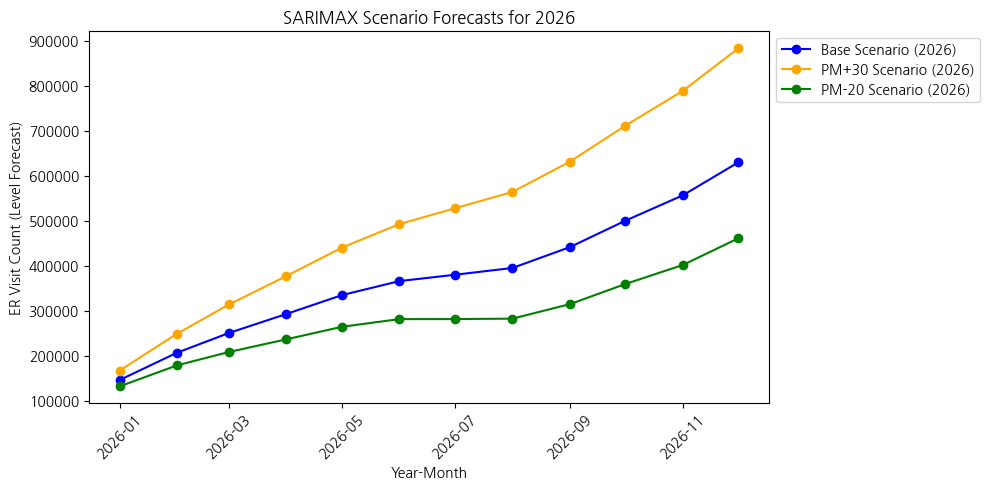

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(future_index, level_base, label='Base Scenario (2026)', color='blue', marker='o')
plt.plot(future_index, level_s1,   label='PM+30 Scenario (2026)', color='orange', marker='o')
plt.plot(future_index, level_s2,   label='PM-20 Scenario (2026)', color='green', marker='o')
plt.xlabel('Year-Month')
plt.ylabel('ER Visit Count (Level Forecast)')
plt.title('SARIMAX Scenario Forecasts for 2026')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.tight_layout()

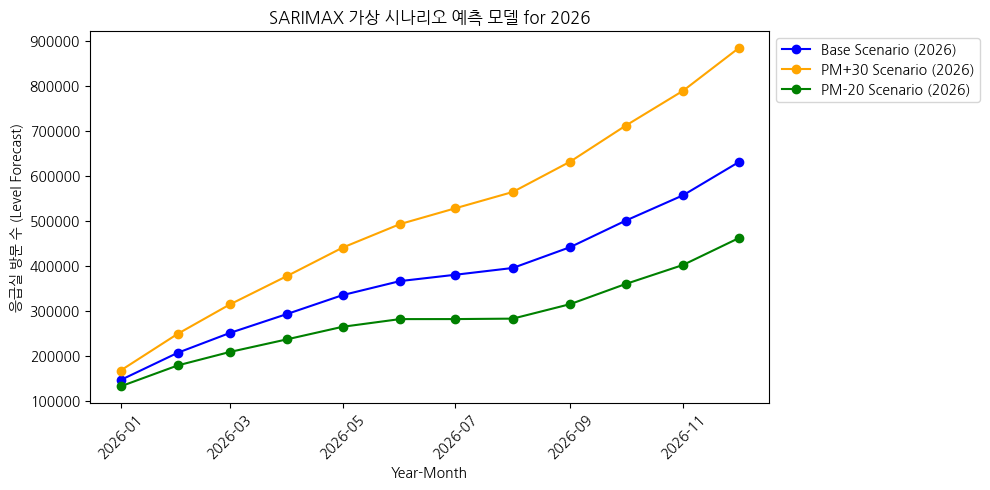

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(future_index, level_base, label='Base Scenario (2026)', color='blue', marker='o')
plt.plot(future_index, level_s1,   label='PM+30 Scenario (2026)', color='orange', marker='o')
plt.plot(future_index, level_s2,   label='PM-20 Scenario (2026)', color='green', marker='o')
plt.xlabel('Year-Month')
plt.ylabel('응급실 방문 수 (Level Forecast)')
plt.title('SARIMAX 가상 시나리오 예측 모델 for 2026')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.tight_layout()